In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings

import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.model_selection import train_test_split

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)
warnings.filterwarnings(action = 'ignore', category=UserWarning)

In [10]:
## 读取数据
path1 = "datas/winequality-red.csv"
df1 = pd.read_csv(path1, sep=";")
df1['type'] = 1 # 设置数据类型为红葡萄酒

path2 = "datas/winequality-white.csv"
df2 = pd.read_csv(path2, sep=";")
df2['type'] = 0 # 设置数据类型为白葡萄酒

# 合并两个df
df = pd.concat([df1,df2], axis=0)

## 自变量名称
names = ["fixed acidity","volatile acidity","citric acid",
         "residual sugar","chlorides","free sulfur dioxide",
         "total sulfur dioxide","density","pH","sulphates",
         "alcohol", "type"]

## 因变量名称
quality = "quality"

In [11]:
## 异常数据处理
new_df = df.replace('?', np.nan)
datas = new_df.dropna(axis=0, how = 'any') # 只要有行为空，就进行删除操作

X = datas[names]
Y = datas[quality]
Y.ravel()

array([5, 5, 5, ..., 6, 7, 6], dtype=int64)

In [6]:
## 创建模型列表
models = [
    Pipeline([
            ('Poly', PolynomialFeatures()),
            ('Linear', LinearRegression())
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures()),
            ('Linear', RidgeCV(alphas=np.logspace(-4, 2, 20)))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures()),
            ('Linear', LassoCV(alphas=np.logspace(-4, 2, 20)))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures()),
            ('Linear', ElasticNetCV(alphas=np.logspace(-4,2, 20), l1_ratio=np.linspace(0, 1, 5)))
        ])
]

线性回归预测:1阶, 截距:103, 系数: [  0.00000000e+00   8.50118207e-02  -1.48620723e+00  -6.90416760e-02
   6.23516751e-02  -7.18643184e-01   4.99059722e-03  -1.45047299e-03
  -1.03460590e+02   4.97432666e-01   7.21153860e-01   2.23033948e-01
   3.51639435e-01]
线性回归预测:2阶, 截距:-709, 系数: [  1.46176871e-05  -2.74516395e+01   9.87661449e+01   2.49676785e+02
  -1.74998936e+01  -1.15483093e+03  -2.43456904e+00   9.13621910e-01
   1.19491591e+03   1.26064733e+02   5.80781883e+01   1.98966670e+01
  -7.77784964e+01  -4.34318334e-02   3.31320957e-02   4.24739823e-01
  -2.31878257e-02  -2.40247894e+00  -7.35719431e-05   3.64009509e-04
   2.78865437e+01   9.27783429e-02   2.07233708e-01   1.34480741e-02
  -5.45491073e-02   4.37670832e-01   8.75879632e-01  -3.84236400e-02
   1.10461091e+00   5.84956242e-03   7.21047495e-03  -1.09383487e+02
   9.44208783e-01   3.90477722e-01   3.15802918e-01   1.20298473e+00
  -1.04158882e+00   6.70367332e-02   6.55542659e+00   8.39269381e-03
  -5.18668353e-04  -2.58961482e+02   

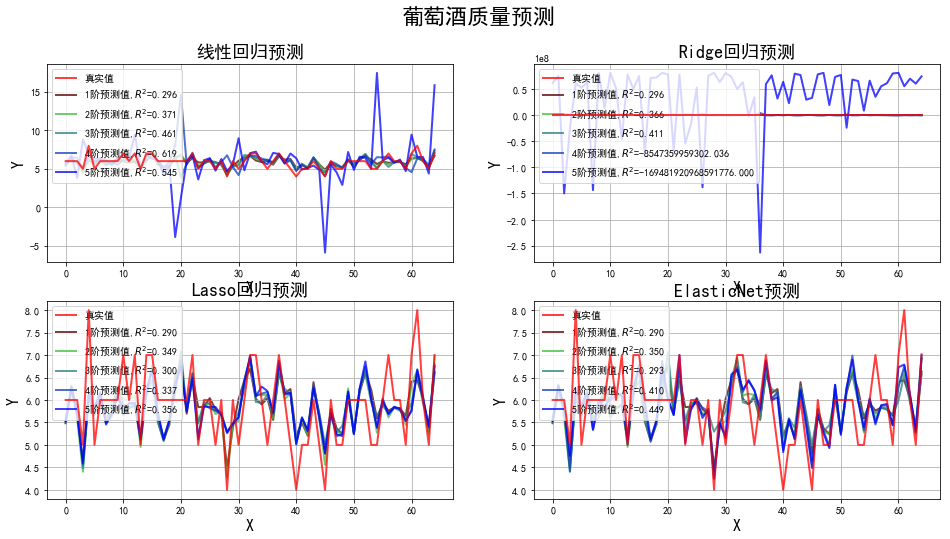

In [17]:
plt.figure(figsize=(16,8), facecolor='w')
titles = u'线性回归预测', u'Ridge回归预测', u'Lasso回归预测', u'ElasticNet预测'

## 将数据分为训练数据和测试数据
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.01, random_state=0)
ln_x_test = range(len(X_test))

## 给定阶以及颜色
d_pool = np.arange(1,4,1) # 1 2 3 阶
m = len(d_pool)
clrs = [] # 颜色
for c in np.linspace(5570560, 255, m):
    clrs.append('#%06x' % int(c))


for t in range(4):
    plt.subplot(2, 2, t + 1)
    model = models[t]
    plt.plot(ln_x_test, Y_test, c='r', lw=2, alpha=0.75, zorder=10, label=u'真实值')
    for i,d in enumerate(d_pool):
        # 设置参数
        model.set_params(Poly__degree=d)
        # 模型训练
        model.fit(X_train, Y_train)
        # 模型预测及计算R^2
        Y_pre = model.predict(X_test)
        ## NOTE: 将Y_pre这种连续性的预测值，转换为离散形式的（转换方式：四舍五入）
        ## NOTE: 既然变成分类的应用的话，那么模型评估指标就不能用R^2，
        ## NOTE: 这里用准确率(两种方式实现，一：numpy原始的实现，二：基于sklearn的相关API实现)
        R = model.score(X_train, Y_train)
        # 输出信息
        lin = model.get_params()['Linear']
        output = u"%s:%d阶, 截距:%d, 系数:" % (titles[t], d, lin.intercept_)
        print(output, lin.coef_)
        ## 图形展示
        plt.plot(ln_x_test, Y_pre, c=clrs[i], lw=2,alpha=0.75, zorder=i, label=u'%d阶预测值,$R^2$=%.3f' % (d,R))
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.title(titles[t], fontsize=18)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
plt.suptitle(u'葡萄酒质量预测', fontsize=22)
plt.show()